In [ ]:
!pip install opencv-python

In [ ]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: protobuf, setuptools, tf-estimator-nightly, opt-einsum, google-pasta, tensorboard, h5py, numpy, astunparse, grpcio, keras, wrapt, keras-preprocessing, gast, six, termcolor, flatbuffers, tensorflow-io-gcs-filesystem, typing-extensions, absl-py, libclang
Required-by: kapre


In [ ]:
!python3 -m pip install tensorflow

     |████████████████████████████████| 462 kB 7.4 MB/s 


In [2]:
#======Importing Libraries==========#
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
#=====================================#

In [3]:
os.getcwd()

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <u>Image Exploration</u>

In [5]:
image_paths = '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/Train' # Path to Folder Containing Image Equations
file_paths = [os.path.join(image_paths,k) for k in sorted(os.listdir(image_paths))] # Image Paths
raw_images = [plt.imread(k) for k in file_paths] # Reading Images

- **Displaying Images**

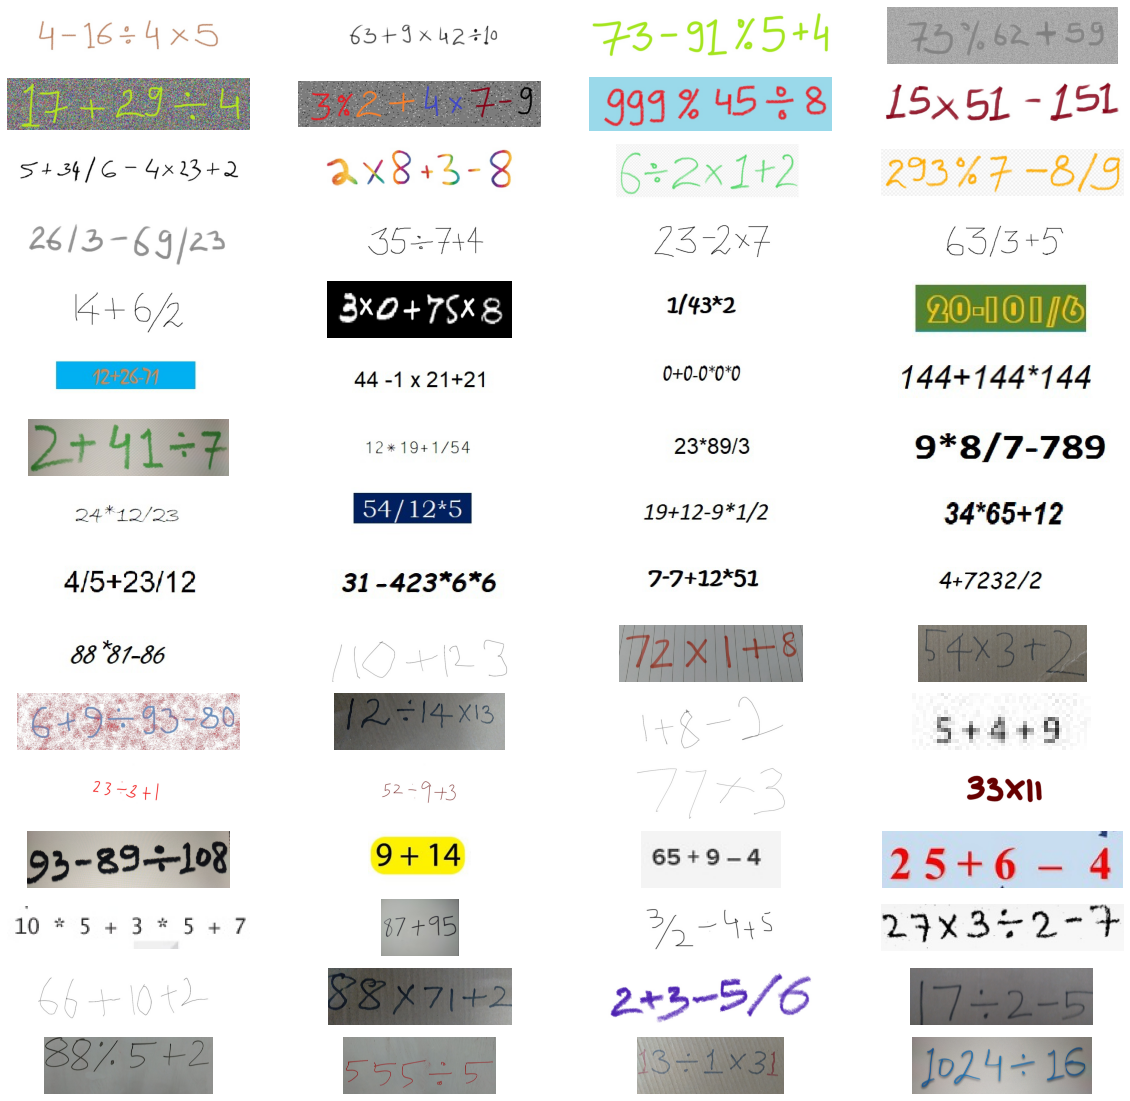

In [12]:
#========Displaying Images======#
plt.figure(figsize=(20,20))

for i,img in enumerate(raw_images):
    plt.subplot(16,4,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()
#==================================#


### Initial Observations

The Following are the Initial Observations based on Visual Inspection of the Images Displayed above

* There are Multiple Categories into which one can place each Image above
* The Background of the Images is not always Monochromatic.
* We Observe Noisy Background.
* We have Images with Non Uniform Illumination Problem. 
* Digits and Operators (Foreground Objects) are not Mono Chromatic and have lot of variations in the Way they are represented i.e. Handwritten vs Digital Format(Font Styles) / Thin Characters vs Thick Characters.
* Also Digits Have the Orientation Problems. i.e. All the Digits and Operators are not written in a Straight Line. 
* Also just by Visual Inspection one can easyily figure out that they have different Sizes.

* Quick Image Stats

Smallest Image Dimension : (16, 50)


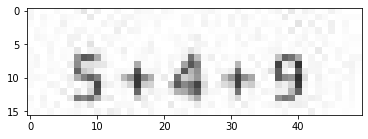


Largest Image Dimension : (1305, 4105)


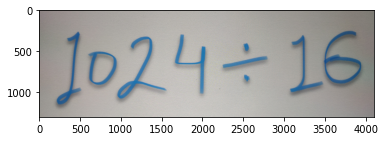

In [14]:
#========Quick Image Statistics============#
image_shapes = [(i,img.shape[:2]) for i,img in enumerate(raw_images)]
sorted_shapes = sorted(image_shapes,key=lambda X : np.product(X[1]))
print('Smallest Image Dimension : {}'.format(sorted_shapes[0][1]))
plt.imshow(raw_images[sorted_shapes[0][0]])
plt.show()
print('\nLargest Image Dimension : {}'.format(sorted_shapes[-1][1]))
plt.imshow(raw_images[sorted_shapes[-1][0]])
plt.show()
#===========================================#

* Image Grayscale Level Distribution

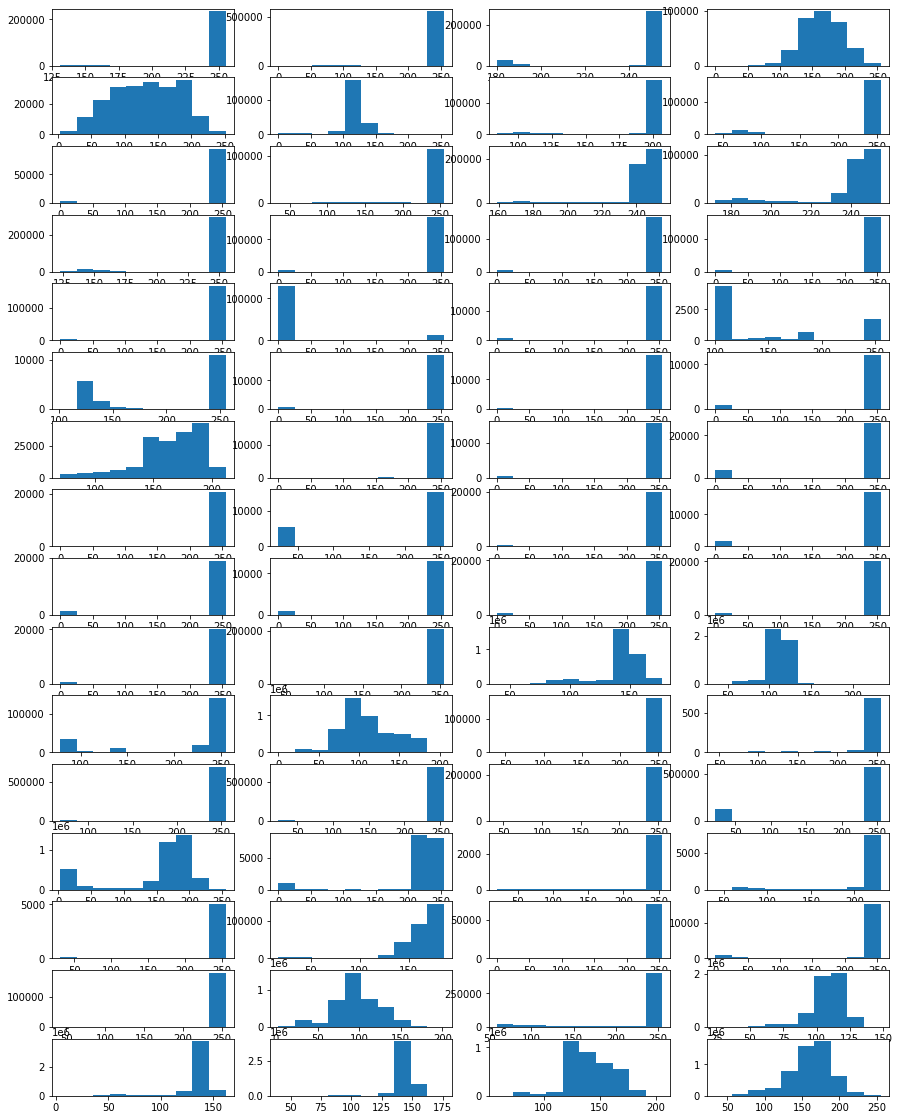

In [15]:
#========Image Graylevel Distribution======#
plt.figure(figsize=(15,20))

for i,img in enumerate(raw_images):
    plt.subplot(16,4,i+1)
    im = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    plt.hist(im.flatten())
plt.show()
#==================================#

### Observations

Based on the Basic Scale Range (Sizes of Images) and Distribution of the GrayLevels of the Image the following could be inferred

* The Scale Range of Images has Lot of Variation i.e. Smallest Image is (16,50) and Largest Image is (1305,4105)
* The Graylevels indicate that most of the Images have Monochromatic Foreground with occasional Salt and Pepper Noise and Few of the Images have Maximum graylevel less than 180 indicating a Darker Image.

* Gaussian and other Noises in Images can be inferred from Distribution of Graylevels Centered around Certain Pixel Value in few of the Images.


# Next step planning

## Required Components to build the Solution

Based on the above observations the task of Image Equation Solver can be Broken down into several Tasks. The following are the Subtasks that form our Wish list and would be Stiched into Solution Pipeline

1) **Image Preprocessing**

2) **Character Segmentation**

3) **Character Identification/Detection**

4) **Post Processing**

5) **Exception Handling and Final Arithemetic String**

# Solution Architechture

The Following is the Block Diagram of the Solution Pipeline at a high level

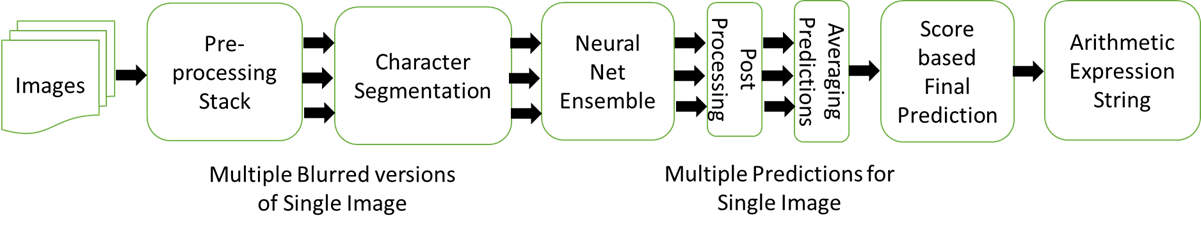

# Lets Implement and Explore each Stage of the Pipeline with an Example

# Denoising and Preprocessing

This is the First Stage in the Solution Pipeline where an Image is denoised with FastN1MeanDenoising and Multiple Blurred versions of the Image are created to Handle Impulse/NonImpulse Noises. Multiple versions are needed for Accurate Character Segmentation and Identification.

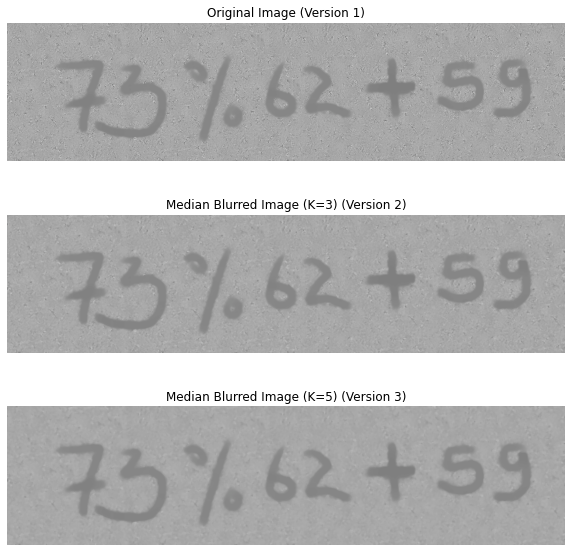

In [16]:
#=========Image Denoising=====================================#
imgref = raw_images[3].copy()
imgref = cv2.fastNlMeansDenoisingColored(imgref,None,10,10,7,21) # Fast Image Denoising
#===============================================================#

#====Median Blurring====#
imgref_3,imgref5 = cv2.medianBlur(imgref,3,-1),cv2.medianBlur(imgref,5,-1)
#=======================#

#=======Plotting Multiple Versions on Image===========#
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.title('Original Image (Version 1)')
plt.imshow(imgref)
plt.axis('off')
plt.subplot(3,1,2)
plt.title('Median Blurred Image (K=3) (Version 2)')
plt.imshow(imgref_3)
plt.axis('off')
plt.subplot(3,1,3)
plt.title('Median Blurred Image (K=5) (Version 3)')
plt.imshow(imgref5)
plt.axis('off')
plt.show()
#==============================#

## CRAFT Text Detection for Character Localization

Character Region Awareness for Text Detection (CRAFT) is a pretrained DeepLeaning Model that is trained to detect Text in Natural Scenes. 

The Main Power of CRAFT Model is the fact that not only it can accrately detect Text in a Natural Scene Image but also can detect the individual Character in the Image and an Affinity Score that would Link Characters to form Words. The Affinity Score estimation of CRAFT makes CRAFT Model Detect Continuos Text even on a Curved Contour.

More Information about CRAFT can be found at : https://arxiv.org/pdf/1904.01941.pdf

The Following Section illustrates CRAFT based Digit and Operator Localization


In [17]:
!pip install craft-text-detector # Official Pytorch Implementation of CRAFT

In [18]:
from craft_text_detector import Craft

In [19]:
import torch

gpuflag = torch.cuda.is_available() # Checking For GPU


craft = Craft(text_threshold=0.4, # Text Detection Threshold
              link_threshold=np.inf, # Link Score is set to infinity so that CRAFT doesnt form Words and WOuld identify Bounding Box of each Character
              crop_type="box",
              cuda=gpuflag) # Using GPU Backend (Change this to False if Working on CPU Backend)

#### Character Localization Method

In [21]:
def localize_chars(img,badj=None):
    '''Method to Localize Character from Image
    
    Parameters
    ----------
    
    img : (Numpy Array) RGB|Grayscale Image
    badj : (int) Border Adjustment Factor
    Returns
    -------

    Chars : (list) List of Numpy Array of Images of Characters
    '''
    Chars = [] # List to Store Characters

    if len(img.shape)==2:
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) # Fast Image Denoising
    detections = craft.detect_text(img) # Detecting Character Bounding Region in Noisy/Natural Scene Image
    bounding_boxes = [cv2.boundingRect(box) for box in detections['boxes']] # Bounding Boxes of Characters
    bounding_boxes = sorted(bounding_boxes,key=lambda X : X[0])
    #===========Cropping Characters from Image=========================#
    for x,y,w,h in bounding_boxes:
        if w>(0.045*img.shape[1]):
            sw,sd = int(np.floor(x)),int(np.floor(y))
            ew,ed = sw+int(np.ceil(w)),sd+int(np.ceil(h))
            if badj:
                sw,sd = max(0,sw-badj),max(0,sd-badj)
                ew,ed = min(ew+badj,img.shape[1]),min(ed+badj,img.shape[0])
            Chars.append(img[sd:ed,sw:ew])
    #===================================================================#
    return Chars

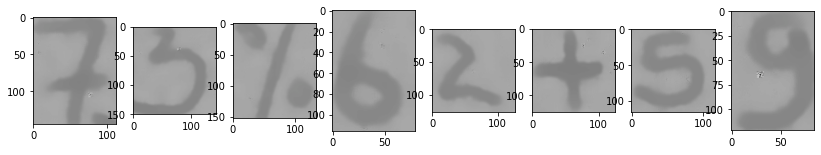

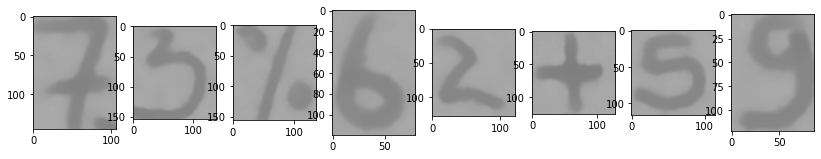

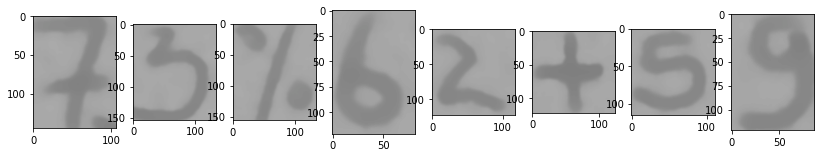

In [22]:
#===========CRAFT Character Localization======================#
Characters = localize_chars(imgref)
plt.figure(figsize=(14,14))
for i,ch in enumerate(Characters):
    plt.subplot(1,len(Characters),i+1)
    plt.imshow(ch)

plt.show()

Characters = localize_chars(imgref_3)
plt.figure(figsize=(14,14))
for i,ch in enumerate(Characters):
    plt.subplot(1,len(Characters),i+1)
    plt.imshow(ch)

plt.show()


Characters = localize_chars(imgref5)
plt.figure(figsize=(14,14))
for i,ch in enumerate(Characters):
    plt.subplot(1,len(Characters),i+1)
    plt.imshow(ch)

plt.show()
#==================================================================#

* The Following are few Examples of Character Segemntation on Raw Images

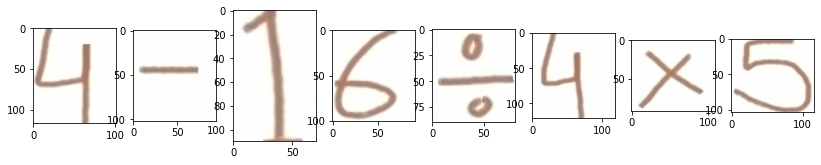

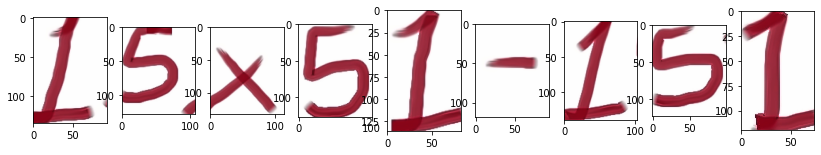

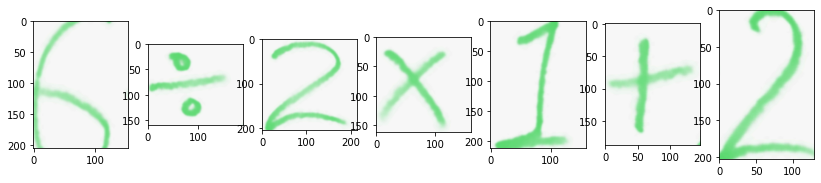

In [23]:
#===========CRAFT Character Localization======================#
Characters = localize_chars(raw_images[0])
plt.figure(figsize=(14,14))
for i,ch in enumerate(Characters):
    plt.subplot(1,len(Characters),i+1)
    plt.imshow(ch)

plt.show()

Characters = localize_chars(raw_images[7])
plt.figure(figsize=(14,14))
for i,ch in enumerate(Characters):
    plt.subplot(1,len(Characters),i+1)
    plt.imshow(ch)

plt.show()


Characters = localize_chars(raw_images[10])
plt.figure(figsize=(14,14))
for i,ch in enumerate(Characters):
    plt.subplot(1,len(Characters),i+1)
    plt.imshow(ch)

plt.show()
#==================================================================#

# Neural Network Ensemble for Character Recognition

### Examples of Training Dataset used for Training the Model

MNIST Training Dataset Sample


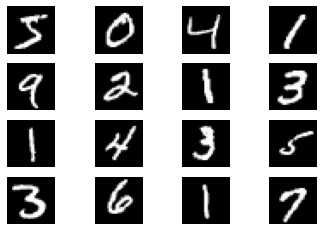

In [24]:
(X_tr,ytr),(X_ts,yts) = tf.keras.datasets.mnist.load_data()
print('MNIST Training Dataset Sample')
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_tr[i],cmap='gray')
    plt.axis('off')
plt.show()

Digital Font Dataset Sample for Digit 4


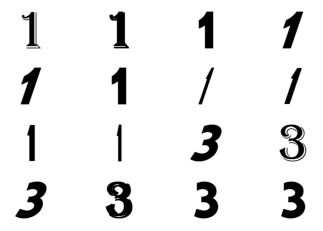

In [25]:
pth = '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/FontSample'
Digital_fonts = [plt.imread(os.path.join(pth,k)) for k in os.listdir(pth)[:16]]
print('Digital Font Dataset Sample for Digit 4')
for i,img in enumerate(Digital_fonts):
    plt.subplot(4,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
plt.show()


Training Sample Examples for Div Symbols "/"


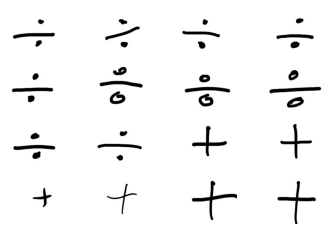

In [26]:
pth = '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/SymbolSample'
Symbols = [plt.imread(os.path.join(pth,k)) for k in os.listdir(pth)[:16]]
print('Training Sample Examples for Div Symbols "/"')
for i,img in enumerate(Symbols):
    plt.subplot(4,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
plt.show()

- Image Data AUgmentation Method

In [27]:
def add_noise(img):
    '''Method to Add Noise and perform Image Augmentation
    This Method is Passed to Image DataGenerator
    
    Parameters
    ----------
    img : (Numpy Array) Original Image transformed by Image DataGenerator

    Returns
    -------
    img : (Numpy Array) Image with Added Noise
    '''
    if np.max(img)<=1:
        img = img * 255
    
    if (np.random.random()<=0.4):
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # Converting Image to Grayscale
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) # Converting Grayscale Image into RGB 3 Channel Image
    #=====Swapping Foreground/Background Randomly===========#
    if (np.random.random()<=0.4): # 
        img = 255 - img
    #========================================================#
    #========Adding Gaussian Noise to Image Color Channels=======#
    if np.random.random()<=0.5:
        shp = img[:,:,0].shape
        img[:,:,0]+=np.random.normal(0,np.random.randint(1,11,1)[0],shp)
        img[:,:,1]+=np.random.normal(0,np.random.randint(1,11,1)[0],shp)
        img[:,:,2]+=np.random.normal(0,np.random.randint(1,11,1)[0],shp)
        img[img>255] = 255
        img[img<0] = 0
    #============================================================#
    return img

* Image DataGenerator

In [28]:
import tensorflow as tf
# #==========Image Data Generator===========================#
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = add_noise,
                                                       zoom_range=0.15,height_shift_range=0.1,width_shift_range=0.1,
                                                       channel_shift_range=45)
# #=========================================================#

traingen = idg.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/eval_train/train',
                                    target_size=(32,32),
                                    batch_size=32,
                                    class_mode='categorical') # Training Generator

valgen = idg.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/eval_train/eval',
                                    target_size=(32,32),
                                    batch_size=32,
                                    class_mode='categorical') # Validation Generator

Found 7609 images belonging to 18 classes.
Found 1021 images belonging to 18 classes.


# Conversion Dictionary

Dictionary Mapping Class Labels Predicted by Network Ensemble to Actual String 

In [29]:
#==========Dictionary Mapping=======================#
conversion_dict = dict(zip(range(10),range(10)))
conversion_dict[10] = '/'
conversion_dict[11] = '-'
conversion_dict[12] = '%'
conversion_dict[13] = '+'
conversion_dict[14] = '*'
#===================================================#

# EfficientNet based Feedforward Classification Network

In [30]:
def getModel():
    '''Method to Create Instance of EfficientNET B1 with Custom Feedforward Head
    
    Parameters
    ----------
    None

    Returns
    -------
    MODEL : (tf.keras.Model) Keras Functional Model
    
    '''
    
    model = tf.keras.applications.EfficientNetB1(include_top=False,input_shape=(32,32,3))
    #=========Freezing BatchNormalization Layers===========#
    for k in model.layers:
        if k.name.endswith('bn'):
            k.trainable = False
    #=======================================================#
    #=====Custom Functional Feedforward Network Classficication Head===#
    ip = tf.keras.layers.Input(shape=(32,32,3))
    GAP = tf.keras.layers.GlobalAveragePooling2D()
    densevec = tf.keras.layers.Dense(1248,activation='relu')
    Y = model(ip)
    Y = GAP(Y)
    Y = densevec(Y)
    Y = tf.keras.layers.Dense(1024,activation='relu')(Y)
    Y = tf.keras.layers.Dropout(0.3)(Y)
    Y = tf.keras.layers.Dense(1024,activation='relu')(Y)
    Y = tf.keras.layers.Dense(512,activation='relu')(Y)
    Y = tf.keras.layers.BatchNormalization()(Y)
    Y = tf.keras.layers.Dense(256,activation='relu')(Y)
    Y = tf.keras.layers.Dense(128,activation='relu')(Y)
    Y = tf.keras.layers.Dropout(0.2)(Y)
    Y = tf.keras.layers.Dense(64,activation='relu')(Y)
    Y = tf.keras.layers.Dense(32,activation='relu')(Y)
    Y = tf.keras.layers.Dropout(0.1)(Y)
    Y = tf.keras.layers.Dense(18,activation='softmax')(Y)
    #=================================================================#
    MODEL = tf.keras.models.Model(ip,Y)
    return MODEL

In [31]:
def getModelEFF(mdl):
    '''Method to retrive Classification Feedforward Head for a Given Base EfficientNetwork
    
    Parameters
    ----------

    mdl : (tf.keras.Model) Backbone Network(EfficientNet B0 to B7)
    
    Returns
    -------
    MODEL : (tf.keras.Model) Custom EfficientNet with Classification Feedforward Head
    '''

    model = mdl(include_top=False,input_shape=(32,32,3))
    #=========Freezing BatchNormalization Layers===========#
    for k in model.layers:
        if k.name.endswith('bn'):
            k.trainable = False
    #=======================================================#
    model.trainable = True
    #===========Classification FeedForward Head=============#
    ip = tf.keras.layers.Input(shape=(32,32,3))
    GAP = tf.keras.layers.GlobalAveragePooling2D()
    densevec = tf.keras.layers.Dense(1248,activation='relu')
    Y = model(ip)
    Y = GAP(Y)
    Y = densevec(Y)
    Y = tf.keras.layers.Dense(1024,activation='relu')(Y)
    Y = tf.keras.layers.Dropout(0.3)(Y)
    Y = tf.keras.layers.Dense(1024,activation='relu')(Y)
    Y = tf.keras.layers.Dense(512,activation='relu')(Y)
    Y = tf.keras.layers.BatchNormalization()(Y)
    Y = tf.keras.layers.Dense(256,activation='relu')(Y)
    Y = tf.keras.layers.Dense(128,activation='relu')(Y)
    Y = tf.keras.layers.Dropout(0.2)(Y)
    Y = tf.keras.layers.Dense(64,activation='relu')(Y)
    Y = tf.keras.layers.Dense(32,activation='relu')(Y)
    Y = tf.keras.layers.Dropout(0.1)(Y)
    Y = tf.keras.layers.Dense(18,activation='softmax')(Y)
    #==========================================================#
    MODEL = tf.keras.models.Model(ip,Y)

    return MODEL

* Assigning Class Weights

In [32]:
#=============Assigning Higher Weights to Operator Classes as they are UnderRepresented====#
weights = dict(zip(range(10),[1 for i in range(10)]))
weights[10] = 3
weights[11] = 3
weights[12] = 3
weights[13] = 3
weights[14] = 3
weights[15] = 3
weights[16] = 3
weights[17] = 3
#===========================================================================================#

In [33]:
def get_weights(factor):
    weights = dict(zip(range(10),[1 for i in range(10)]))
    weights[10] = factor
    weights[11] = factor
    weights[12] = factor
    weights[13] = factor
    weights[14] = factor
    weights[15] = factor
    weights[16] = factor
    weights[17] = factor
    return weights


- The Following is the Architecture of the Base EfficientNetB4

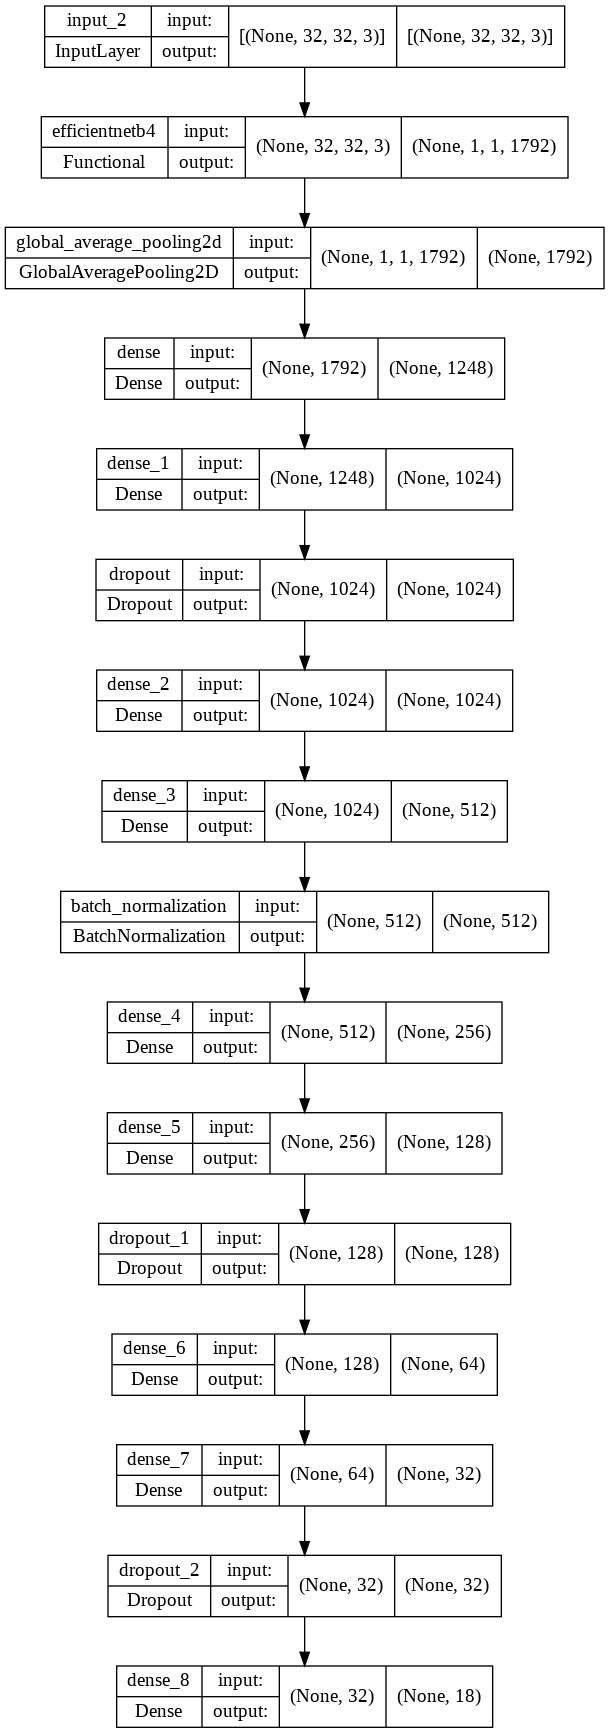

In [34]:
tf.keras.utils.plot_model(getModelEFF(tf.keras.applications.EfficientNetB4),show_shapes=True)

# Training Networks

**Unhide this Section to View the Code that has been used to Train Neural Networks**

## The Following Code has been used to Train

* **EfficientNetB4_English_Font_UnWeighted** 
* **EfficientNetB4_English_Font_Weighted_2x** 
* **EfficientNetB4_English_Font_Weighted_3x** 

**(Models train on English Font Images of (0-9) , MNIST and Math Symbols Dataset)**

In [ ]:
###### this portion should be executed only to generate the trained network models

'''
#=======Creating EffinetB4 based Feedforword Networks for Classfication======#
EFF_B1 = getModelEFF(tf.keras.applications.EfficientNetB4)
EFF_B2 = getModelEFF(tf.keras.applications.EfficientNetB4)
EFF_B3 = getModelEFF(tf.keras.applications.EfficientNetB4)
#==============================================================================#

#==========Compiling Models====================================================#
EFF_B1.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(),metrics=['accuracy'])
EFF_B2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(),metrics=['accuracy'])
EFF_B3.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(),metrics=['accuracy'])
#===============================================================================#

#========Model Callbacks=======================#
es1 = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
mchk1 = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/ATTEMP2/EFFB1.hdf5',save_best_only=True)
cbacks1 = [es1,mchk1]

es2 = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
mchk2 = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/ATTEMP2/EFFB2.hdf5',save_best_only=True)
cbacks2 = [es2,mchk2]

es3 = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)
mchk3 = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/ATTEMP2/EFFB3.hdf5',save_best_only=True)
cbacks3 = [es3,mchk3]
#==========================================#


#========Training the Models=======================================#

history1 = EFF_B1.fit(traingen,
                            validation_data=valgen,
                            epochs=10,
                            verbose=1,
                            steps_per_epoch=100,
                            validation_steps=80,
                            callbacks=[cbacks1]) # Unweighted Loss Function

history2 = EFF_B2.fit(traingen,
                            validation_data=valgen,
                            epochs=10,
                            verbose=1,
                            steps_per_epoch=100,  
                            validation_steps=80,
                            callbacks=[cbacks2],
                            class_weight=get_weights(2)) # Weighted Loss Function (2X)

history3 = EFF_B3.fit(traingen,
                            validation_data=valgen,
                            epochs=10,
                            verbose=1,
                            steps_per_epoch=100,  
                            validation_steps=80,
                            callbacks=[cbacks3],
                            class_weight=get_weights(3)) # Weighted Loss Function (3X)

#=================================================================#

'''

Epoch 1/10
100/100 [==============================] - 203s 2s/step - loss: 2.8866 - accuracy: 0.0688 - val_loss: 2.8834 - val_accuracy: 0.0852
Epoch 2/10
100/100 [==============================] - 166s 2s/step - loss: 2.8114 - accuracy: 0.1009
Epoch 3/10
100/100 [==============================] - 164s 2s/step - loss: 2.7381 - accuracy: 0.1331
Epoch 4/10
100/100 [==============================] - 161s 2s/step - loss: 2.5875 - accuracy: 0.1723
Epoch 5/10
100/100 [==============================] - 162s 2s/step - loss: 2.3966 - accuracy: 0.2391
Epoch 6/10
100/100 [==============================] - 162s 2s/step - loss: 2.2339 - accuracy: 0.2897
Epoch 7/10
100/100 [==============================] - 163s 2s/step - loss: 2.0057 - accuracy: 0.3407
Epoch 8/10
100/100 [==============================] - 163s 2s/step - loss: 1.7996 - accuracy: 0.4150
Epoch 9/10
100/100 [==============================] - 161s 2s/step - loss: 1.6811 - accuracy: 0.4472
Epoch 10/10
100/100 [============================

## The Following Code has been used to Train

**EfficientNetB1_MNIST_Weighted_3x to EfficientNetB5_MNIST_Weighted_3x** 

**(Models Trained on MNIST and Math Symbols Dataset)**

### This segment is executed to train the model and models are stored as hdf5 files

In [51]:
'''
MODEL = getModel()
MODEL.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
mchk = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet.hdf5',save_best_only=True)
callbacks = [early_stopping,mchk]

history = MODEL.fit(traingen,
                    validation_data=valgen, 
                    verbose=1,
                    epochs=10,
                    steps_per_epoch=100, 
                    validation_steps=81,callbacks=[callbacks],class_weight=weights)
'''

Epoch 1/10
100/100 [==============================] - 912s 9s/step - loss: 5.3054 - accuracy: 0.0758 - val_loss: 2.9060 - val_accuracy: 0.0529
Epoch 2/10
100/100 [==============================] - 377s 4s/step - loss: 5.0572 - accuracy: 0.0728
Epoch 3/10
100/100 [==============================] - 216s 2s/step - loss: 4.7928 - accuracy: 0.0991
Epoch 4/10
100/100 [==============================] - 132s 1s/step - loss: 4.5924 - accuracy: 0.1244
Epoch 5/10
100/100 [==============================] - 84s 839ms/step - loss: 3.9358 - accuracy: 0.2045
Epoch 6/10
100/100 [==============================] - 59s 587ms/step - loss: 2.8939 - accuracy: 0.3661
Epoch 7/10
100/100 [==============================] - 39s 388ms/step - loss: 2.2773 - accuracy: 0.4825
Epoch 8/10
100/100 [==============================] - 35s 340ms/step - loss: 1.7559 - accuracy: 0.6075
Epoch 9/10
100/100 [==============================] - 27s 274ms/step - loss: 1.4256 - accuracy: 0.6768
Epoch 10/10
100/100 [==================

In [52]:
'''
MODEL2 = getModelEFF(tf.keras.applications.EfficientNetB2)

MODEL2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
mchk = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B2.hdf5',save_best_only=True)
callbacks = [early_stopping,mchk]

history = MODEL2.fit(traingen,
                    validation_data=valgen, 
                    verbose=1,
                    epochs=10,
                    steps_per_epoch=100, 
                    validation_steps=81,callbacks=[callbacks],class_weight=weights)
'''

31801344/31790344 [==============================] - 1s 0us/step
Epoch 1/10
100/100 [==============================] - 47s 302ms/step - loss: 5.1830 - accuracy: 0.0774 - val_loss: 2.9011 - val_accuracy: 0.0441
Epoch 2/10
100/100 [==============================] - 21s 208ms/step - loss: 4.7361 - accuracy: 0.1159
Epoch 3/10
100/100 [==============================] - 20s 195ms/step - loss: 4.4112 - accuracy: 0.1628
Epoch 4/10
100/100 [==============================] - 20s 194ms/step - loss: 4.0387 - accuracy: 0.1929
Epoch 5/10
100/100 [==============================] - 20s 194ms/step - loss: 3.5810 - accuracy: 0.2399
Epoch 6/10
100/100 [==============================] - 20s 197ms/step - loss: 3.3474 - accuracy: 0.3194
Epoch 7/10
100/100 [==============================] - 20s 194ms/step - loss: 2.8393 - accuracy: 0.4106
Epoch 8/10
100/100 [==============================] - 19s 192ms/step - loss: 2.5363 - accuracy: 0.4485
Epoch 9/10
100/100 [==============================] - 20s 194ms/step 

In [53]:
'''
MODEL3 = getModelEFF(tf.keras.applications.EfficientNetB3)

MODEL3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
mchk = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B3.hdf5',save_best_only=True)
callbacks = [early_stopping,mchk]

history = MODEL3.fit(traingen,
                    validation_data=valgen, 
                    verbose=1,
                    epochs=10,
                    steps_per_epoch=100, 
                    validation_steps=81,callbacks=[callbacks],class_weight=weights)
'''

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 50s 303ms/step - loss: 5.3204 - accuracy: 0.0625 - val_loss: 2.9056 - val_accuracy: 0.0617
Epoch 2/10
100/100 [==============================] - 20s 200ms/step - loss: 4.8128 - accuracy: 0.1063
Epoch 3/10
100/100 [==============================] - 21s 213ms/step - loss: 4.2557 - accuracy: 0.1763
Epoch 4/10
100/100 [==============================] - 20s 201ms/step - loss: 4.0199 - accuracy: 0.2113
Epoch 5/10
100/100 [==============================] - 20s 203ms/step - loss: 3.7514 - accuracy: 0.2447
Epoch 6/10
100/100 [==============================] - 20s 202ms/step - loss: 3.4032 - accuracy: 0.3091
Epoch 7/10
100/100 [==============================] - 20s 201ms/step - loss: 2.9825 - accuracy: 0.3519
Epoch 8/10
100/100 [==============================] - 20s 198ms/step - loss: 2.5965 - accuracy: 0.4372
Epoch 9/10
100/100 [==============================] - 20s 203ms/step 

In [54]:
'''
MODEL4 = getModelEFF(tf.keras.applications.EfficientNetB4)

MODEL4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
mchk = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B4.hdf5',save_best_only=True)
callbacks = [early_stopping,mchk]

history = MODEL4.fit(traingen,
                    validation_data=valgen, 
                    verbose=1,
                    epochs=10,
                    steps_per_epoch=100, 
                    validation_steps=81,callbacks=[callbacks],class_weight=weights)
'''

Epoch 1/10
100/100 [==============================] - 58s 332ms/step - loss: 5.1640 - accuracy: 0.0737 - val_loss: 2.8962 - val_accuracy: 0.0833
Epoch 2/10
100/100 [==============================] - 22s 219ms/step - loss: 4.6888 - accuracy: 0.1416
Epoch 3/10
100/100 [==============================] - 22s 214ms/step - loss: 4.0319 - accuracy: 0.2150
Epoch 4/10
100/100 [==============================] - 23s 231ms/step - loss: 3.5656 - accuracy: 0.2744
Epoch 5/10
100/100 [==============================] - 22s 214ms/step - loss: 3.0908 - accuracy: 0.3709
Epoch 6/10
100/100 [==============================] - 22s 217ms/step - loss: 2.6654 - accuracy: 0.4516
Epoch 7/10
100/100 [==============================] - 22s 218ms/step - loss: 2.4218 - accuracy: 0.4948
Epoch 8/10
100/100 [==============================] - 22s 218ms/step - loss: 2.1521 - accuracy: 0.5288
Epoch 9/10
100/100 [==============================] - 22s 216ms/step - loss: 1.9774 - accuracy: 0.5816
Epoch 10/10
100/100 [==========

In [55]:
'''
MODEL5 = getModelEFF(tf.keras.applications.EfficientNetB5)

MODEL5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy']) 


early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
mchk = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B5.hdf5',save_best_only=True)
callbacks = [early_stopping,mchk]

history = MODEL5.fit(traingen,
                    validation_data=valgen, 
                    verbose=1,
                    epochs=10,
                    steps_per_epoch=100, 
                    validation_steps=81,callbacks=[callbacks],class_weight=weights)
'''

115277824/115263384 [==============================] - 1s 0us/step
Epoch 1/10
100/100 [==============================] - 68s 393ms/step - loss: 5.2587 - accuracy: 0.0561 - val_loss: 3.5021 - val_accuracy: 0.0509
Epoch 2/10
100/100 [==============================] - 25s 250ms/step - loss: 4.9532 - accuracy: 0.0922
Epoch 3/10
100/100 [==============================] - 24s 243ms/step - loss: 4.5520 - accuracy: 0.1425
Epoch 4/10
100/100 [==============================] - 24s 242ms/step - loss: 4.2076 - accuracy: 0.1691
Epoch 5/10
100/100 [==============================] - 24s 242ms/step - loss: 3.8665 - accuracy: 0.2275
Epoch 6/10
100/100 [==============================] - 24s 238ms/step - loss: 3.5056 - accuracy: 0.2772
Epoch 7/10
100/100 [==============================] - 24s 237ms/step - loss: 3.1329 - accuracy: 0.3370
Epoch 8/10
100/100 [==============================] - 24s 240ms/step - loss: 2.7860 - accuracy: 0.3963
Epoch 9/10
100/100 [==============================] - 24s 242ms/ste

# Creating Model Stack

In [56]:

#==========Paths to Model Stack that were trained on oversampled operator(/,+,-,%,*) Classes====#
paths = [
         '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/ATTEMP2/EFFB2.hdf5',
         '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/ATTEMP2/EFFB3.hdf5',
         '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/ATTEMP2/EFFB1.hdf5'
         ]

#===============================================================================================#
#==========Paths to Model Stack without Oversampling=====================#
paths2 = ['/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet.hdf5',
          '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B2.hdf5',
         '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B3.hdf5',
         '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B4.hdf5',
         '/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/UpdatedMathnet/Mathnet_B5.hdf5'
          ]
#====================================================================================#
paths = paths + paths2

model_list = [tf.keras.models.load_model(pth) for pth in paths] # List of Models used for Prediction

#==========Renaming Models===========================================#
model_list[0]._name = 'EfficientNetB4_English_Font_Weighted_2x'
model_list[1]._name = 'EfficientNetB4_English_Font_Weighted_3x'
model_list[2]._name = 'EfficientNetB4_English_Font_UnWeighted'
model_list[3]._name = 'EfficientNetB1_MNIST_Weighted_3x'
model_list[4]._name = 'EfficientNetB2_MNIST_Weighted_3x'
model_list[5]._name = 'EfficientNetB3_MNIST_Weighted_3x'
model_list[6]._name = 'EfficientNetB4_MNIST_Weighted_3x'
model_list[7]._name = 'EfficientNetB5_MNIST_Weighted_3x'
#====================================================================#

#===========Model Stack===========#
ip = tf.keras.layers.Input((32,32,3))
Outs =[m(ip) for m in model_list]
y = tf.keras.layers.Average()(Outs)
model = tf.keras.models.Model(ip,y)
model.save('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/FinalStack.hdf5')
#===================================#


In [41]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/FinalStack.hdf5')

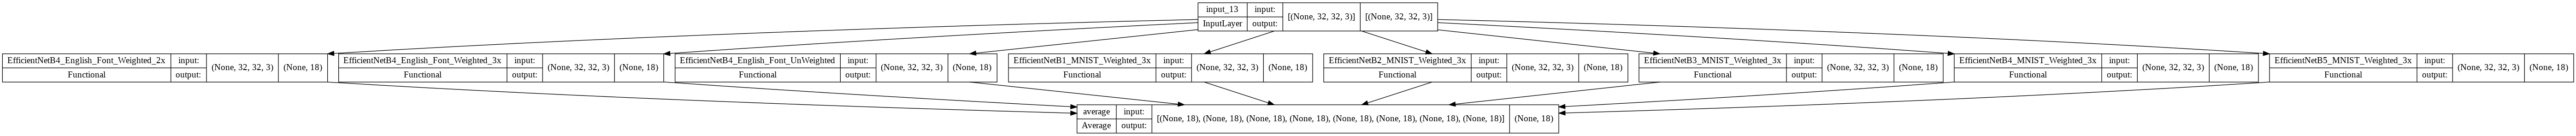

In [57]:
tf.keras.utils.plot_model(model,to_file="/content/drive/MyDrive/Colab Notebooks/ImageEquationSolver/model.png",show_shapes=True)

# Stacked Model Architecture

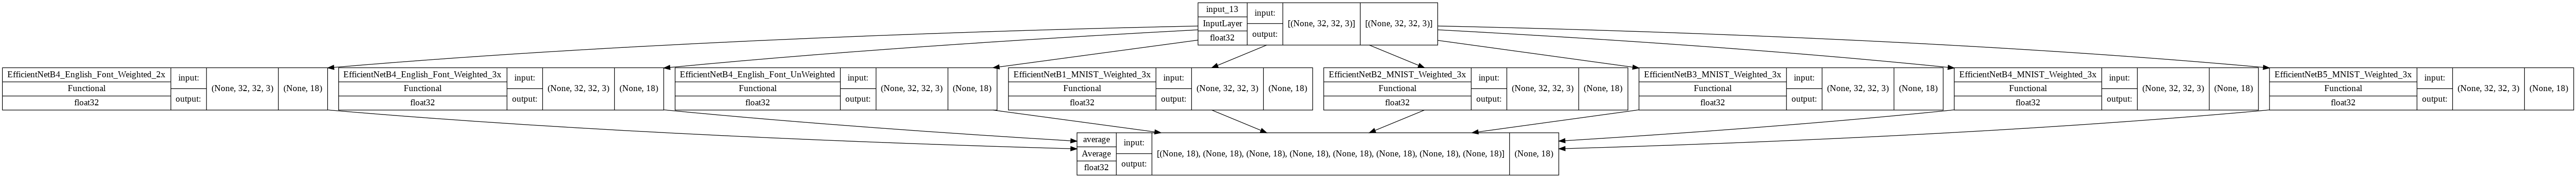

In [58]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

# Post Processing Methods

Post processing Methods are required as a part of any OCR Solutions that can help to Correct Misclassfications and FineTune the Extraction Results

One Post Processing task we perform is handling misclassification of **"/"** as **1**. 

During Training since MNIST Dataset has many **1's** that look like forward slash **/** it is expected that classfier may predict **/** as **1**

Thr Following is the Post Processing Approach
* **Identify Characters predicted as 1 by Neural Network Ensemble**
* **Perform ForeGround Seperation on Corresponding Character Image using KMeans Clustering**
* **Fit an Ellipse on the Foreground Segmented Image to get Inclination of the Character** 
* **If the Angle of Inclination is between 12 to 90 degrees then 1 is replaced with /**

Note : The above Post Processing Method is invoked if a Character is predicted as 1 by the Network Ensemble and the Charcters to the left and Right are predicted as Numbers by the Network. It is a Logical way of Applying Correction as we cannot have a valid Arithemetic Expression where an operator has another operator in its immediate Neighbourhood  


In [35]:
from sklearn.cluster import KMeans

In [36]:
def CharMask(img):
    '''Method to Create a Binary Mask of Character Image to Seperate ForeGround from Background
    
    Parameters
    ----------
    img : (Numpy Array) Character Image

    Returns

    labs : (Numpy Array) Character Binary Mask
    '''
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) # Fast Image Denoising

    #====Grayscale Conversion and Equalization=====#
    imbw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if (len(np.where(imbw<=210)[0])<10):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        img[:,:,2] = cv2.equalizeHist(img[:,:,2])
        img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    #===============================================#
    #=========Foreground Seperation using KMeans Clustering===#
    imrs = img.copy()
    km = KMeans(2) # Two Clusters (ForeGround and Background)
    labs = km.fit_predict(imrs.reshape(np.product(imrs.shape[:2]),3))
    labs = labs.reshape(img.shape[:2])
    labs = labs.astype('uint8')
    nwhite = np.sum(labs)
    nblack = np.product(labs.shape)-nwhite
    if nwhite>nblack:
        labs = 1-labs
    labs = labs*255
    #==============================================================#
    return labs

In [37]:
def correct_one(char):
    '''Method to detect if the Character is 1 or '/' 
    
    Parameters
    ----------
    char : (Numpy Array) Cropped Character Image
    
    Returns
    -------
    true_char : (str) True Character
    '''
    maskedchar = CharMask(char) # Masking the Character to Create Binary Image
    contours,h = cv2.findContours(maskedchar,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # COntour Approximation
    contours = sorted(contours,key=lambda X : cv2.contourArea(X),reverse=True)
    angle = (cv2.fitEllipse(contours[0]))[-1] # Fitting Ellipse to Estimate the Angle of Inclination
    true_char = '/' if (angle>12 and angle<90) else '1'
    return true_char

* Example

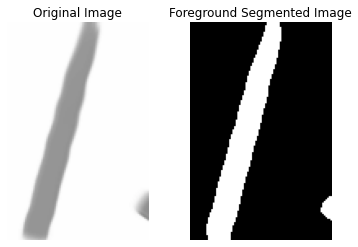

In [38]:
Chars = localize_chars(raw_images[12])
imref = Chars[2]
maskedref = CharMask(imref)
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(imref)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Foreground Segmented Image')
plt.imshow(maskedref,cmap='gray')
plt.axis('off')
plt.show()


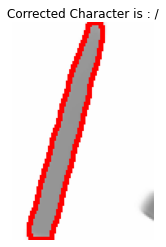

In [39]:
contours,h = cv2.findContours(maskedref,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # COntour Approximation
contours = sorted(contours,key=lambda X : cv2.contourArea(X),reverse=True)
plottable = imref.copy()
cv2.drawContours(plottable,contours,0,(255,0,0),2)
chr = correct_one(imref) # Applying Correction
plt.title('Corrected Character is : {}'.format(chr))
plt.imshow(plottable)
plt.axis('off')
plt.show()

# Evaluating the Model on Subset of Training Images Provided

As Mentioned in the Orginal Pipeline/BlockDiagram, we perform extraction using 3 different Variants of Input Image i.e. Original Image, Median Blurred with K=3 and Median Blurred with K=5 and choose the result that has either maximized Number of Detected Characters or has Maximized the Total Probability over all the Characters

In [47]:
import re

model_list = [model]
def evaluate_score(model_list,img,medianblur=False,ksize=5,badj=None):
    '''Method to Parse Image Expression
    
    Parameters
    ----------

    model_list : (list) List of Tensorflow Model Objects
    
    img : (Numpy Array) Image

    medianblur : (Bool) Flag to Indicate Blurring Operation to be performed on Image

    ksize : (int) Odd Integer to Specify the Kernal Size used for Median Blurring

    badj : (int) Border Ajustment Factor. Number of Pixels around the Bounding Box of Character to be Considered as Final Bounding Box

    Returns
    -------
    expr : (string) Predicted String
    Predict : (Predicted Probability Scores)
    '''
    #========Blurring the Image====================#
    if medianblur:
        img = cv2.medianBlur(img,ksize,-1)
    #==============================================#
    Images = localize_chars(img,badj) # Character Localization 
    #==========Image preprocessing=================#
    Imagesr = [cv2.resize(img,(32,32)) for img in Images]
    ECHARS = np.vstack([np.expand_dims(img,0) for img in Imagesr])
    #==============================================#
    #=========Model Ensemble Prediction===============#
    Model_preds = [mod.predict(ECHARS) for mod in model_list] # Loading Models
    Prediction = np.zeros((len(Images),18)) # Array to store final Predicted Probabilities
    #=====Iterating over Models and Predicting Characters==========#
    for pred in Model_preds:
        Prediction+=pred    
    Predict = Prediction/len(model_list) # Averaging Predictions
    Prediction = np.argmax(Predict,1) # Extracting Class Labels
    Prediction = Prediction.flatten()
    #==================================================================#
    expr = ''.join([str(conversion_dict[k]) for k in Prediction]) # Parsed Expression
    #=======================================================#
    #===========PostProcessing==============================#
    #=======================================================#
    idxs_1 = [k.span()[0] for k in re.finditer(r'1',expr)] # Extracting Indices of 1
    
    #======Eliminating Invalid Locations in String where "/"" could have been misclassified as 1====#
    if 0 in idxs_1:
        idxs_1.pop(idxs_1.index(0))

    if (len(expr)-1) in idxs_1:
        idxs_1.pop(idxs_1.index((len(expr)-1)))
    
    if len(idxs_1)>0:
        pop_idxs = []
        for idx in idxs_1:
            if (expr[idx-1].isnumeric() and expr[idx+1].isnumeric()):
                pass
            else:
                pop_idxs.append(idx)

        if len(pop_idxs)>0:
            for idx in pop_idxs:
                idxs_1.pop(idxs_1.index(idx))
    
    tlist = ['_']*len(expr)
    for i in range(len(expr)):
        if i in idxs_1:
            tlist[i] = correct_one(Images[i])
        else:
            tlist[i] = expr[i]
    #===============================================================#
    expr = ''.join(tlist) # Final Expression
    #===============================================================#
    return expr,Predict

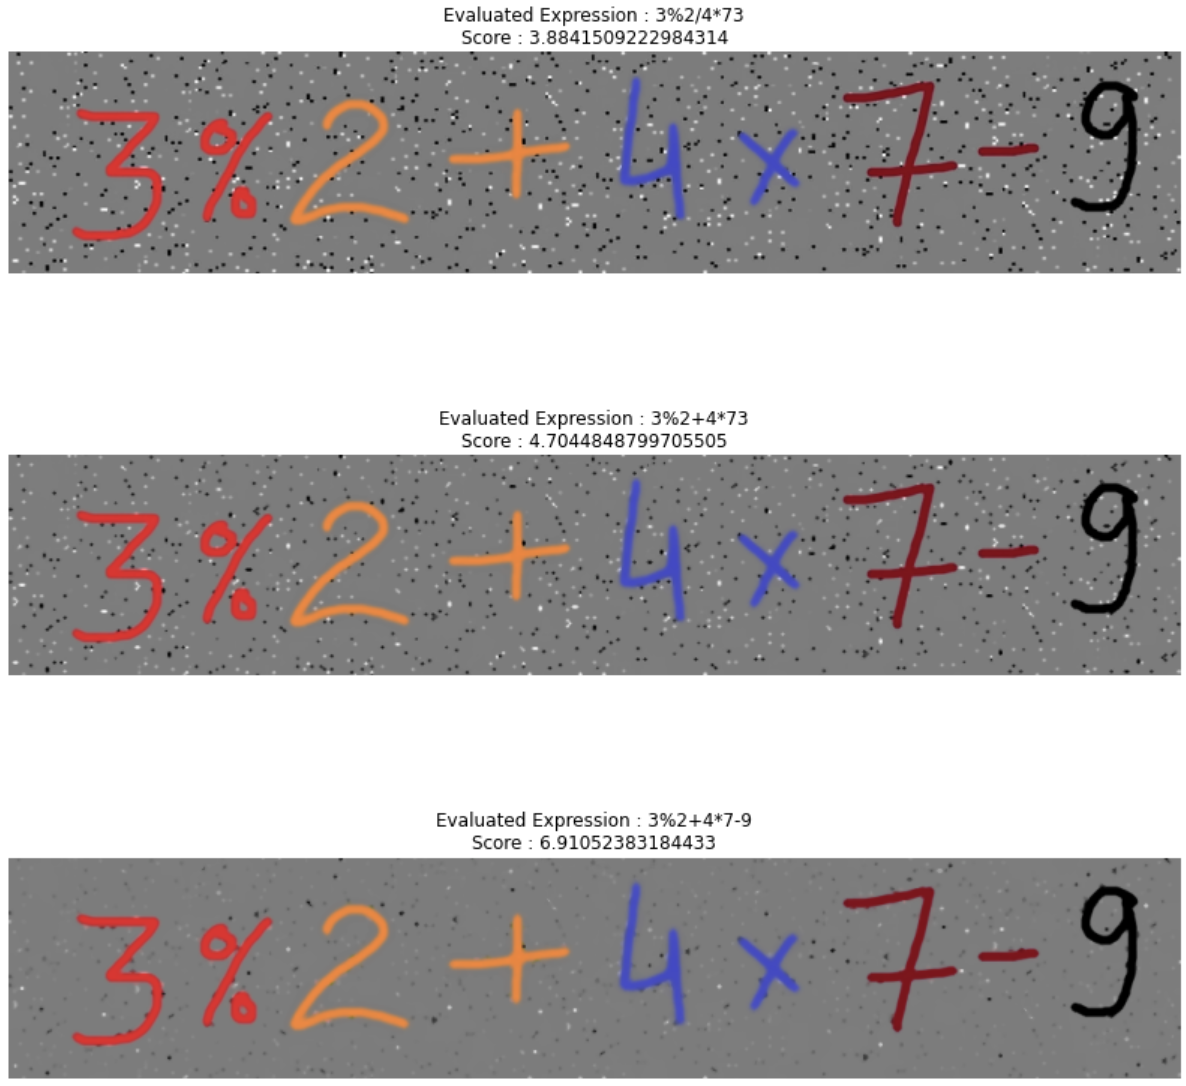

In [52]:
Expression,Score = evaluate_score(model_list,imgref,medianblur=False) # Image without Blurring
Expression2,Score2 = evaluate_score(model_list,imgref,medianblur=True,ksize=3) # Image with Median Blurring (k=3)
Expression3,Score3 = evaluate_score(model_list,imgref,medianblur=True,ksize=5) # Image with Median Blurring (k=5)

plt.figure(figsize=(14,14))
plt.subplot(3,1,1)
plt.title('Evaluated Expression : {}\nScore : {}'.format(Expression,np.sum(np.max(Score,1))))
plt.imshow(imgref)
plt.axis('off')
plt.subplot(3,1,2)
plt.title('Evaluated Expression : {}\nScore : {}'.format(Expression2,np.sum(np.max(Score2,1))))
plt.imshow(imgref_3)
plt.axis('off')
plt.subplot(3,1,3)
plt.imshow(imgref5)
plt.title('Evaluated Expression : {}\nScore : {}'.format(Expression3,np.sum(np.max(Score3,1))))
plt.axis('off')
plt.show()

As shown above the Noisy version of the Image has shown some Misclassifications and due to improper Character Segmentations Results were not Good. However if we obsevere the Median Blurred Version with k=5, the ensemble is able to correctly identify the Expression. 

The Final Predicted Expression from Multiple Versions of Image is Selected based on the Following Scoring Criterion

* The Image which results in Maximum Number of Characters predicted(i.e. Length of Predicted String is Maximum) is chosen as the Final Predicted Expression. 

* If Multiple Versions of Image result in Same number of Predicted Characters then score is calculated as Sum of Predicted Probabilties of each character in the Evaluated string and the expression with maximum score is Selected as Final Expression.

In [53]:
def nwayevaluate(img,badj=None):
    '''Method to Perform Median Blurring and Choose the Best Output

    Parameters
    ----------

    img : (Numpy Array) Image

    badj : (int) Border Ajustment Factor. Number of Pixels around the Bounding Box of Character to be Considered as Final Bounding Box
    
    Returns
    -------
    EXPR : (String) Parsed Expression
    
    '''
    EXPR= None
    blurdict = {}
    blurdict['0'] = evaluate_score(model_list,img,badj=badj)
    blurdict['1'] = evaluate_score(model_list,img,medianblur=True,ksize=3,badj=badj)
    blurdict['2'] = evaluate_score(model_list,img,medianblur=True,ksize=5,badj=badj)
    Lengths = [len(blurdict[str(i)][0]) for i in range(3)]
    nmax = Lengths.count(np.max(Lengths))
    if nmax==1:
        idx = Lengths.index(np.max(Lengths))
        EXPR = blurdict[str(idx)][0]
    else:
        idxs = [i for i,k in enumerate(Lengths) if k==np.max(Lengths)]
        score = sorted([blurdict[str(i)] for i in idxs],key=lambda X : np.sum(np.max(X[1],1)),reverse=True)
        EXPR,score = score[0]
    
    return EXPR

# Example Results on Training Images

/usr/local/lib/python3.7/dist-packages/craft_text_detector/craft_utils.py:403: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray  polys = np.array(polys)
/usr/local/lib/python3.7/dist-packages/craft_text_detector/predict.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray  polys_as_ratio = np.array(polys_as_ratio)


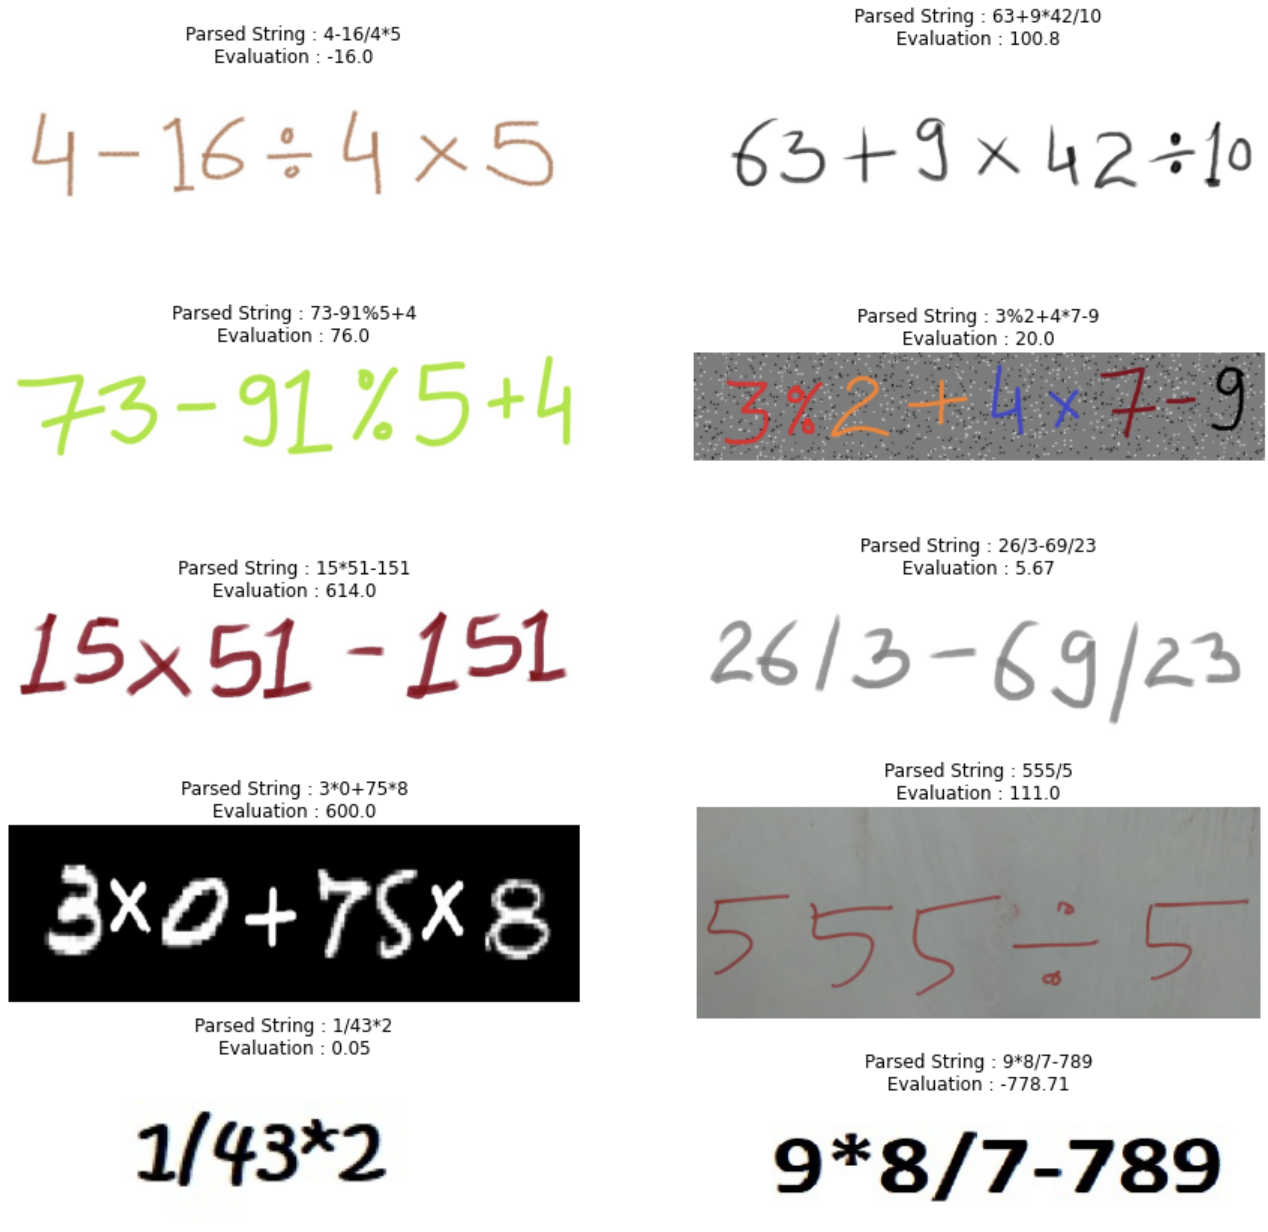

In [54]:
idxs = [0,1,2,5,7,12,17,-3,18,27]
plt.figure(figsize=(15,15))
for i,idx in enumerate(idxs):
    expr1 = nwayevaluate(Raw_images[idx])
    result1 = np.round(float(eval(expr1)),2)
    plt.subplot(5,2,i+1)
    plt.title('Parsed String : {}\nEvaluation : {}'.format(expr1,result1))
    plt.imshow(Raw_images[idx])
    plt.axis('off')

plt.show()

# Final Pipeline for Evaluation and Exception Handling

The above results are the examples where the Custom Image Equation Solver Pipeline is able to predict th Characters with very High Accuracy. 

It should be noted that not all the Images that are provided can be parsed and extract Valid Output. There are Cases where there would be misclassification or incorrected Character Localization that could lead to inconsistent Results.

To Handle all such cases where the Parsing was not Successfull or has resulted in an **Invalid Arithematic Expression** we will use the **EASYOCR** to parse the Results. This way we have a **combination** of Both Custom Logic and State of the ART OCR Solution that can help us to minimize error and Improve Extraction Accuracy at a Character Level. 


# Note : Please use the Following Code to evaluate results on New Images. 

Make sure that all the methods and Variables defined in this Notebook except the ones that are commented are exceuted Before running the Following Method. The Parts of the Code that are not needed for Evaluation purposes have been commented for the ease of running all the Cells at Once.

* Installing Packages Used in this Notebook other than regular Python and CV Packages

In [40]:
!pip install craft-text-detector # Official Pytorch Implementation of CRAFT
!pip install easyocr

     |████████████████████████████████| 70.8 MB 17 kB/s 
     |████████████████████████████████| 47.6 MB 54.5 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from craft_text_detector import Craft
import easyocr

In [ ]:
import torch
#=========Variables=========================#
gpuflag = torch.cuda.is_available()
reader = easyocr.Reader(['en'],gpu=gpuflag)
craft = Craft(text_threshold=0.4, # Text Detection Threshold
              link_threshold=np.inf, # Link Score is set to infinity so that CRAFT doesnt form Words and WOuld identify Bounding Box of each Character
              crop_type="box",
              cuda=gpuflag) # Using GPU Backend (Change this to False if Working on CPU Backend)
#===========================================#

### ImageSolver Class (End to End pipeline)

In [ ]:
class ImageSolver:
    '''Image Equation Solver Class'''

    def __init__(self,model_path = 'FinalStack.hdf5'):
        '''ImageSolver Class Constructor'''
        self.model = tf.keras.models.load_model(model_path)
        self.Images = None # Attribute to Store Raw Images
        self.eval = None # Attribute to Store Evaluated Arithmetic Expression DataFrame


    def parseimages(self,dirpath,dstpath='Expressions.csv'):
        '''Method to Parse Images in 
        Directory and Extract Arithemetic Expressions
        
        Parameters
        ---------

        dirpath : (String) Path to Directory containing Images to be parsed

        dstpath : (String) Destination Path pf File with Evaluated Results

        Returns
        -------

        df : (Pandas DataFrame) Parsed Results
        '''
        self.Images = [plt.imread(os.path.join(dirpath,k)) for k in os.listdir(dirpath)] # Reading Images
        filenames = [k for k in os.listdir(dirpath)]
        #======Evaluation===================================================#
        Expressions,Evaluations = [],[] # List to Store Expressions and Evaluations
        for img in self.Images:
            try:
                expr = ImageSolver.nwayevaluate(self.model,img) # Evaluating Expression using Efficienet Ensemble
                result = np.round(float(eval(expr)),2) # Evaluating Result
                Expressions.append(expr) # Appending Expressions
                Evaluations.append(result) # Appending Evaluated Expressions
            except Exception as e:
                #====Invoking EasyOCR=========#
                result = ''
                try:
                    valid_list = ['0','1','2','3','4','5'
                                    ,'6','7','8','9','x','X',
                                    '*','+','-','/','%'] # List of Valid Characters for Arithemetic Expression Evaluation
                    
                    expr = reader.readtext(img) # Parsed Results
                    expr = ''.join([k for k in expr[0][-2] if k in valid_list]) # Filtering Results
                    expr = expr.lower().replace('x','*') # Arithemetic Expression
                    result = eval(expr)
                except:
                    pass
                
                Expressions.append(expr) # Appending Expressions
                Evaluations.append(result) # Appending Evaluated Expressions
                #==============================#

        column_names = ['ImageName','Parsed Arithemetic Expression','Evaluation'] # Column Names
        df = pd.DataFrame(zip(filenames,Expressions,Evaluations),columns=column_names)
        self.eval = df.copy(deep=True)
        df.to_csv(dstpath,index=False)
        return df

    
    
    @staticmethod
    def nwayevaluate(model,img,badj=None):
        '''Method to Perform Median Blurring and Choose the Best Output

        Parameters
        ----------

        img : (Numpy Array) Image

        badj : (int) Border Ajustment Factor. Number of Pixels around the Bounding Box of Character to be Considered as Final Bounding Box
        
        Returns
        -------
        EXPR : (String) Parsed Expression
        
        '''
        EXPR= None
        blurdict = {}
        blurdict['0'] = ImageSolver.evaluate_score(model,img,badj=badj)
        blurdict['1'] = ImageSolver.evaluate_score(model,img,medianblur=True,ksize=3,badj=badj)
        blurdict['2'] = ImageSolver.evaluate_score(model,img,medianblur=True,ksize=5,badj=badj)
        Lengths = [len(blurdict[str(i)][0]) for i in range(3)]
        nmax = Lengths.count(np.max(Lengths))
        if nmax==1:
            idx = Lengths.index(np.max(Lengths))
            EXPR = blurdict[str(idx)][0]
        else:
            idxs = [i for i,k in enumerate(Lengths) if k==np.max(Lengths)]
            score = sorted([blurdict[str(i)] for i in idxs],key=lambda X : np.sum(np.max(X[1],1)),reverse=True)
            EXPR,score = score[0]
        
        return EXPR
    
    
    @staticmethod
    def correct_one(char):
        '''Method to detect if the Character is 1 or '/' 
        
        Parameters
        ----------
        char : (Numpy Array) Cropped Character Image
        
        Returns
        -------
        true_char : (str) True Character
        '''
        maskedchar = ImageSolver.CharMask(char) # Masking the Character to Create Binary Image
        contours,h = cv2.findContours(maskedchar,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # COntour Approximation
        contours = sorted(contours,key=lambda X : cv2.contourArea(X),reverse=True)
        angle = (cv2.fitEllipse(contours[0]))[-1] # Fitting Ellipse to Estimate the Angle of Inclination
        true_char = '/' if (angle>12 and angle<90) else '1'
        return true_char
    

    @staticmethod
    def CharMask(img):
        '''Method to Create a Binary Mask of Character Image to Seperate ForeGround from Background
        
        Parameters
        ----------
        img : (Numpy Array) Character Image

        Returns

        labs : (Numpy Array) Character Binary Mask
        '''
        img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) # Fast Image Denoising

        #====Grayscale Conversion and Equalization=====#
        imbw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        if (len(np.where(imbw<=210)[0])<10):
            img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
            img[:,:,2] = cv2.equalizeHist(img[:,:,2])
            img = cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
        #===============================================#
        #=========Foreground Seperation using KMeans Clustering===#
        imrs = img.copy()
        km = KMeans(2) # Two Clusters (ForeGround and Background)
        labs = km.fit_predict(imrs.reshape(np.product(imrs.shape[:2]),3))
        labs = labs.reshape(img.shape[:2])
        labs = labs.astype('uint8')
        nwhite = np.sum(labs)
        nblack = np.product(labs.shape)-nwhite
        if nwhite>nblack:
            labs = 1-labs
        labs = labs*255
        #==============================================================#
        return labs
    
    @staticmethod
    def localize_chars(img,badj=None):
        '''Method to Localize Character from Image
        
        Parameters
        ----------
        
        img : (Numpy Array) RGB|Grayscale Image
        badj : (int) Border Adjustment Factor
        Returns
        -------

        Chars : (list) List of Numpy Array of Images of Characters
        '''
        Chars = [] # List to Store Characters

        if len(img.shape)==2:
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

        img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) # Fast Image Denoising
        detections = craft.detect_text(img) # Detecting Character Bounding Region in Noisy/Natural Scene Image
        bounding_boxes = [cv2.boundingRect(box) for box in detections['boxes']] # Bounding Boxes of Characters
        bounding_boxes = sorted(bounding_boxes,key=lambda X : X[0])
        #===========Cropping Characters from Image=========================#
        for x,y,w,h in bounding_boxes:
            if w>(0.045*img.shape[1]):
                sw,sd = int(np.floor(x)),int(np.floor(y))
                ew,ed = sw+int(np.ceil(w)),sd+int(np.ceil(h))
                if badj:
                    sw,sd = max(0,sw-badj),max(0,sd-badj)
                    ew,ed = min(ew+badj,img.shape[1]),min(ed+badj,img.shape[0])
                Chars.append(img[sd:ed,sw:ew])
        #===================================================================#
        return Chars
    
    @staticmethod
    def evaluate_score(model,img,medianblur=False,ksize=5,badj=None):
        '''Method to Parse Image Expression
        
        Parameters
        ----------

        model : (Tensorflow Model Object) 
        
        img : (Numpy Array) Image

        medianblur : (Bool) Flag to Indicate Blurring Operation to be performed on Image

        ksize : (int) Odd Integer to Specify the Kernal Size used for Median Blurring

        badj : (int) Border Ajustment Factor. Number of Pixels around the Bounding Box of Character to be Considered as Final Bounding Box

        Returns
        -------
        expr : (string) Predicted String
        Predict : (Predicted Probability Scores)
        '''
        #=======Image Magnitude Scaling=========#
        if np.max(img)<=1:
            img = 255*img
        #=======================================#
        #========Blurring the Image====================#
        if medianblur:
            img = cv2.medianBlur(img,ksize,-1)
        #==============================================#
        Images = ImageSolver.localize_chars(img,badj) # Character Localization 
        #==========Image preprocessing=================#
        Imagesr = [cv2.resize(img,(32,32)) for img in Images]
        ECHARS = np.vstack([np.expand_dims(img,0) for img in Imagesr])
        Predict = model.predict(ECHARS) # Predicting Character Classes
        Prediction = np.argmax(Predict,1) # Extracting Class Labels
        Prediction = Prediction.flatten()
        #==================================================================#
        expr = ''.join([str(ImageSolver.conversion_dict[k]) for k in Prediction]) # Parsed Expression
        #=======================================================#
        #===========PostProcessing==============================#
        #=======================================================#
        idxs_1 = [k.span()[0] for k in re.finditer(r'1',expr)] # Extracting Indices of 1
        
        #======Eliminating Invalid Locations in String where "/"" could have been misclassified as 1====#
        if 0 in idxs_1:
            idxs_1.pop(idxs_1.index(0))

        if (len(expr)-1) in idxs_1:
            idxs_1.pop(idxs_1.index((len(expr)-1)))
        
        if len(idxs_1)>0:
            pop_idxs = []
            for idx in idxs_1:
                if (expr[idx-1].isnumeric() and expr[idx+1].isnumeric()):
                    pass
                else:
                    pop_idxs.append(idx)

            if len(pop_idxs)>0:
                for idx in pop_idxs:
                    idxs_1.pop(idxs_1.index(idx))
        
        tlist = ['_']*len(expr)
        for i in range(len(expr)):
            if i in idxs_1:
                tlist[i] = ImageSolver.correct_one(Images[i])
            else:
                tlist[i] = expr[i]
        #===============================================================#
        expr = ''.join(tlist) # Final Expression
        #===============================================================#
        return expr,Predict
    
    #==========Dictionary Mapping=======================#
    conversion_dict = dict(zip(range(10),range(10)))
    conversion_dict[10] = '/'
    conversion_dict[11] = '-'
    conversion_dict[12] = '%'
    conversion_dict[13] = '+'
    conversion_dict[14] = '*'
    #===================================================#